# Time Series Geometric Chains

In this tutorial, we briefly explain Geometrically-Enhanced Time Series Chain, as proposed in the [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164) research paper. We implement the algorithm using stumpy package and reproduce some the results.


Note: If this is your first time reading about chains, we recommend you to check out the [Tutorial on Time Seires Chain](Tutorial_Time_Series_Chains.ipynb) first, and then come back here.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import itertools

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

In [3]:
#Extra:
import math

import io
import os
from zipfile import ZipFile
from urllib.request import urlopen

## What is Geometrically-Enhanced Time Series Chain?

Geometrically-Enhanced Time Series Chain, hereafter referred to as G_Chain in this Tutorial, takes a geometric approach in identifying a chain in a time series data. As opposed to the time series chain published in [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf), G_Chain considers the directionality of the chain to avoid identifying random spurious chain (wandering chain). Therefore G_Chain can achieve more meaningful chains. The image below is from the paper that shows a directional chain (left) versus a wandering chain (right).


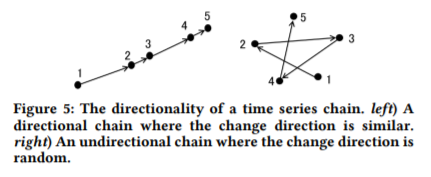

Note: It is worthwhile to note that the authors of G_Chain claim that the reason that the original chain algorithm may find  random spurious chain is that it uses euclidean distance. However, one might use DTW (e.g. see [Matrix Profile XXII](https://www.cs.ucr.edu/~eamonn/DTWMotifsSWAMP_Expanded.pdf)), where normalizing the subsequences are allowed, and then find the chains using the original algorithm proposed in [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf).

Now, let's see how these two algorithms performs on different case studies provided in the paper [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164)